**Components**

These are the core building blocks you can use when building applications.

**Chat models**

Chat Models are newer forms of language models that take messages in and output a message. See supported integrations for details on getting started with chat models from a specific provider.

**How to: do function/tool calling**

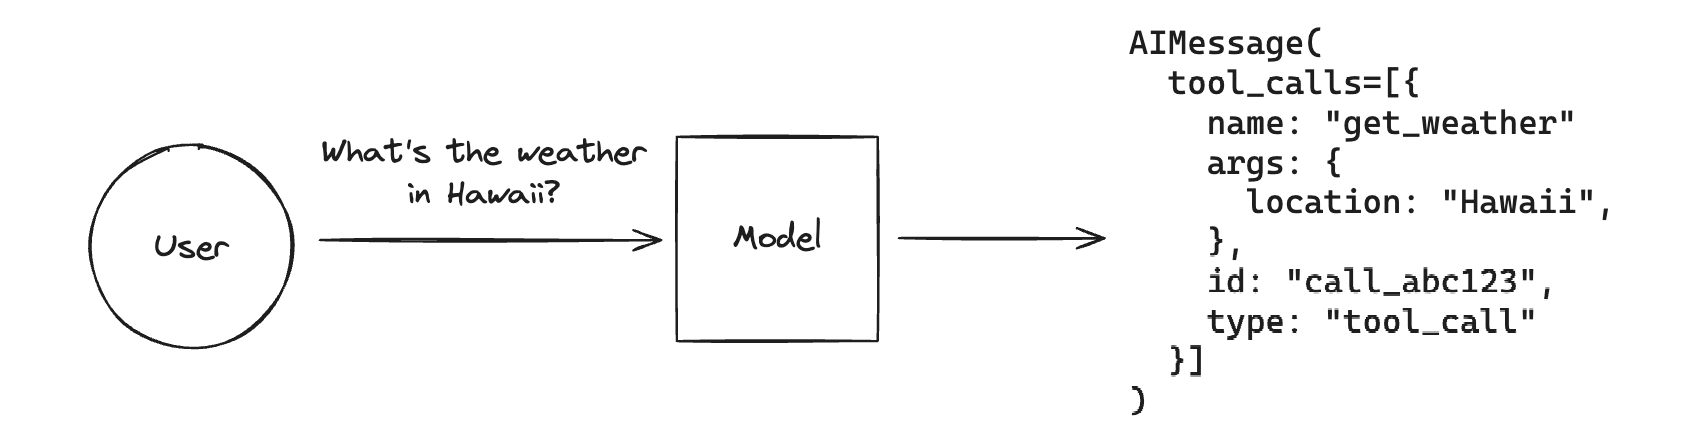



**How to use chat models to call tools**

Tool calling allows a chat model to respond to a given prompt by "calling a tool".

Tool calling is a general technique that generates structured output from a model, and you can use it even when you don't intend to invoke any tools. An example use-case of that is extraction from unstructured text.

**Defining tool schemas**

For a model to be able to call tools, we need to pass in tool schemas that describe what the tool does and what it's arguments are. Chat models that support tool calling features implement a .bind_tools() method for passing tool schemas to the model. Tool schemas can be passed in as Python functions (with typehints and docstrings), Pydantic models, TypedDict classes, or LangChain Tool objects. Subsequent invocations of the model will pass in these tool schemas along with the prompt.

In [ ]:
# The function name, type hints, and docstring are all part of the tool
# schema that's passed to the model. Defining good, descriptive schemas
# is an extension of prompt engineering and is an important part of
# getting models to perform well.
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b


def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

In [ ]:
!pip install -qU "langchain[mistralai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.0 MB/s eta 0:00:00


In [ ]:
tools = [add, multiply]

In [ ]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("mistral-large-latest", model_provider="mistralai")

Enter API key for Mistral AI: ··········


In [ ]:
llm_with_tools = llm.bind_tools(tools)

query = "What is 3 * 12?"

llm_with_tools.invoke(query)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'UTDVvajm3', 'function': {'name': 'multiply', 'arguments': '{"a": 3, "b": 12}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 178, 'total_tokens': 205, 'completion_tokens': 27}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run-bad7bc47-4da6-4d22-9a11-d21d579b8d0e-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'UTDVvajm3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 178, 'output_tokens': 27, 'total_tokens': 205})

In [ ]:
query = "What is 3 * 12? Also, what is 11 + 49?"

llm_with_tools.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': '33wXXNxlz',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 11, 'b': 49},
  'id': 'XvTljUiRe',
  'type': 'tool_call'}]

In [ ]:
query = "What is 3 * 12? Also, what is 11 + 49?"

async for chunk in llm_with_tools.astream(query):
    print(chunk.tool_call_chunks)

[]
[{'name': 'multiply', 'args': '{"a": 3, "b": 12}', 'id': 'ZrBb13SCQ', 'index': 0, 'type': 'tool_call_chunk'}, {'name': 'add', 'args': '{"a": 11, "b": 49}', 'id': 'WCvQALoaX', 'index': 1, 'type': 'tool_call_chunk'}]


**How to return structured data from a model**

It is often useful to have a model return output that matches a specific schema. One common use-case is extracting data from text to insert into a database or use with some other downstream system. This guide covers a few strategies for getting structured outputs from a model.

**The .with_structured_output() method**

This method takes a schema as input which specifies the names, types, and descriptions of the desired output attributes. The method returns a model-like Runnable, except that instead of outputting strings or messages it outputs objects corresponding to the given schema. The schema can be specified as a TypedDict class, JSON Schema or a Pydantic class. If TypedDict or JSON Schema are used then a dictionary will be returned by the Runnable, and if a Pydantic class is used then a Pydantic object will be returned.

In [ ]:
json_schema = {
    "title": "joke",
    "description": "Joke to tell user.",
    "type": "object",
    "properties": {
        "setup": {
            "type": "string",
            "description": "The setup of the joke",
        },
        "punchline": {
            "type": "string",
            "description": "The punchline to the joke",
        },
        "rating": {
            "type": "integer",
            "description": "How funny the joke is, from 1 to 10",
            "default": None,
        },
    },
    "required": ["setup", "punchline", "rating"],
}
structured_llm = llm.with_structured_output(json_schema)

structured_llm.invoke("Tell me a joke about cats")

{'setup': "Why don't cats play poker in the wild?",
 'punchline': 'Too many cheetahs!',
 'rating': 7}

**Streaming**

We can stream outputs from our structured model when the output type is a dict (i.e., when the schema is specified as a TypedDict class or JSON Schema dict).

In [ ]:
for chunk in structured_llm.stream("Tell me a joke about cats"):
    print(chunk)

{'setup': "Why don't cats play poker in the wild?", 'punchline': 'Too many cheetahs!', 'rating': 7}


**How to cache chat model responses**

LangChain provides an optional caching layer for chat models. This is useful for two main reasons:

1) It can save you money by reducing the number of API calls you make to the LLM provider, if you're often requesting the same completion multiple times. This is especially useful during app development.

2) It can speed up your application by reducing the number of API calls you make to the LLM provider.

**In Memory Cache**

This is an ephemeral cache that stores model calls in memory. It will be wiped when your environment restarts, and is not shared across processes.

In [ ]:
# <!-- ruff: noqa: F821 -->
from langchain_core.globals import set_llm_cache

In [ ]:
%%time
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

# The first time, it is not yet in cache, so it should take longer
llm.invoke("Tell me a joke")

CPU times: user 14.6 ms, sys: 1.03 ms, total: 15.6 ms
Wall time: 926 ms


AIMessage(content="Sure, here's one for you:\n\nWhat do you call a fake noodle?\n\nAn impasta!", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 7, 'total_tokens': 35, 'completion_tokens': 28}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-a3fffc96-541f-45cb-95a5-54c077a7e489-0', usage_metadata={'input_tokens': 7, 'output_tokens': 28, 'total_tokens': 35})

In [ ]:
%%time

# The first time, it is not yet in cache, so it should take longer
llm.invoke("Tell me a joke")

CPU times: user 1.63 ms, sys: 0 ns, total: 1.63 ms
Wall time: 4.65 ms


AIMessage(content='What do you call fake spaghetti? An impasta', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 7, 'total_tokens': 21, 'completion_tokens': 14}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-e1727bab-2223-4422-b702-34dc364660a9-0', usage_metadata={'input_tokens': 7, 'output_tokens': 14, 'total_tokens': 21})

**SQLite Cache**

This cache implementation uses a SQLite database to store responses, and will last across process restarts.

In [ ]:
!rm .langchain.db
!pip install langchain-community

rm: cannot remove '.langchain.db': No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
# We can do the same thing with a SQLite cache
from langchain_community.cache import SQLiteCache

set_llm_cache(SQLiteCache(database_path=".langchain.db"))

In [ ]:
%%time
# The first time, it is not yet in cache, so it should take longer
llm.invoke("Tell me a joke")

CPU times: user 35.3 ms, sys: 3.03 ms, total: 38.3 ms
Wall time: 1.08 s


AIMessage(content="Sure, here's one for you:\n\nWhat do you call fake spaghetti?\n\nAn impasta!", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 7, 'total_tokens': 35, 'completion_tokens': 28}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-ee4b14c9-378d-400e-a634-8a2fe037e4db-0', usage_metadata={'input_tokens': 7, 'output_tokens': 28, 'total_tokens': 35})

In [ ]:
%%time
# The second time it is, so it goes faster
llm.invoke("Tell me a joke")

CPU times: user 4.16 ms, sys: 145 µs, total: 4.31 ms
Wall time: 12.5 ms


AIMessage(content="Sure, here's one for you:\n\nWhat do you call fake spaghetti?\n\nAn impasta!", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 7, 'total_tokens': 35, 'completion_tokens': 28}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-ee4b14c9-378d-400e-a634-8a2fe037e4db-0', usage_metadata={'input_tokens': 7, 'output_tokens': 28, 'total_tokens': 35})

**Messages**

Chat models take messages as inputs and return a message as output.

LangChain has a few built-in message types:

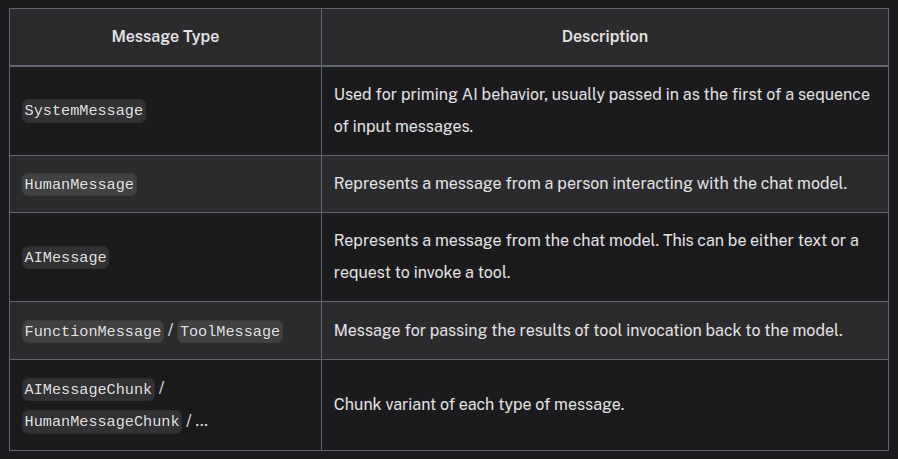

**How to stream chat model responses**

In [33]:
!pip install -qU "langchain-nvidia-ai-endpoints"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.5 MB/s eta 0:00:00


In [34]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY"):
  os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("meta/llama3-70b-instruct", model_provider="nvidia")

In [ ]:
model.invoke("Hello, world!")

AIMessage(content="The classic greeting! Hello, world! It's great to have you here. Is there something on your mind that you'd like to talk about, or are you just feeling excited to be alive and interacting with a chatbot like me? Either way, I'm happy to chat with you and see where the conversation takes us!", additional_kwargs={}, response_metadata={'role': 'assistant', 'content': "The classic greeting! Hello, world! It's great to have you here. Is there something on your mind that you'd like to talk about, or are you just feeling excited to be alive and interacting with a chatbot like me? Either way, I'm happy to chat with you and see where the conversation takes us!", 'token_usage': {'prompt_tokens': 14, 'total_tokens': 81, 'completion_tokens': 67}, 'finish_reason': 'stop', 'model_name': 'meta/llama3-70b-instruct'}, id='run-bf125cd3-7bd1-49ce-a3cb-197858b1c00b-0', usage_metadata={'input_tokens': 14, 'output_tokens': 67, 'total_tokens': 81}, role='assistant')

**How to stream chat model responses**

All chat models implement the Runnable interface, which comes with a default implementations of standard runnable methods (i.e. ainvoke, batch, abatch, stream, astream, astream_events).

The default streaming implementation provides anIterator (or AsyncIterator for asynchronous streaming) that yields a single value: the final output from the underlying chat model provider.



**Sync streaming**

Below we use a | to help visualize the delimiter between tokens.

In [ ]:
for chunk in model.stream("Write me a 1 verse song about goldfish on the moon"):
    print(chunk.content, end="|", flush=True)

|Here| is| a| |1|-|verse| song| about| gold|fish| on| the| moon|:

|"On| the| moon|'s| gray|,| crater|ed| shore|,
|A| school| of| gold|fish| swim| once| more|,
|In| a| sea| of| stars|,| they| glide| and| play|,
|Their| scales| shimmer|ing| in| the| lunar| bay|"||

**Async Streaming**

In [ ]:
async for chunk in model.astream("Write me a 1 verse song about goldfish on the moon"):
    print(chunk.content, end="|", flush=True)

|Here| is| a| |1|-|verse| song| about| gold|fish| on| the| moon|:

|"On| the| moon|'s| gray|,| crater|ed| shore|,
|A| school| of| gold|fish| swim| once| more|,
|In| a| sea| of| stars|,| they| glide| and| play|,
|Their| scales| shimmer|ing| in| the| lunar| bay|"||

**How to stream tool calls**

In [ ]:
llm = init_chat_model("meta/llama3-70b-instruct", model_provider="nvidia")
llm_with_tools = llm.bind_tools(tools)

/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:591: UserWarning: Model 'meta/llama3-70b-instruct' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


In [ ]:
query = "What is 3 * 12? Also, what is 11 + 49?"

for chunk in llm_with_tools.stream(query):
    print(chunk.tool_call_chunks)

[]
[{'name': 'multiply', 'args': '{"a": 3, "b": 12}', 'id': 'dDBpoWb0d', 'index': 0, 'type': 'tool_call_chunk'}, {'name': 'add', 'args': '{"a": 11, "b": 49}', 'id': 'ecuj78kHQ', 'index': 1, 'type': 'tool_call_chunk'}]


**How to use few-shot prompting with tool calling**

For more complex tool use it's very useful to add few-shot examples to the prompt. We can do this by adding AIMessages with ToolCalls and corresponding ToolMessages to our prompt.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

examples = [
    HumanMessage(
        "What's the product of 3000 and 4 plus four", name="example_user"
    ),
    AIMessage(
        "",
        name="example_assistant",
        tool_calls=[
            {"name": "Multiply", "args": {"x": 3000, "y": 4}, "id": "1"}
        ],
    ),
    ToolMessage("12000", tool_call_id="1"),
    AIMessage(
        "",
        name="example_assistant",
        tool_calls=[
            {"name": "Add", "args": {"x": 12000, "y": 4}, "id": "2"}
            ],
    ),
    ToolMessage("12004", tool_call_id="2"),
    AIMessage(
        "The product of 3000 and 4 plus four is 12004",
        name="example_assistant",
    ),
]

system = """You are bad at math but are an expert at using a calculator.

Use past tool usage as an example of how to correctly use the tools."""
few_shot_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        *examples,
        ("human", "{query}"),
    ]
)

chain = {"query": RunnablePassthrough()} | few_shot_prompt | llm_with_tools
chain.invoke("Whats 119 times 8 minus 20").tool_calls

[{'name': 'multiply',
  'args': {'a': 119, 'b': 8},
  'id': 'yD4sQVVc1',
  'type': 'tool_call'}]

**Prompt templates**

Prompt Templates are responsible for formatting user input into a format that can be passed to a language model.

**Create a formatter for the few-shot examples**

Configure a formatter that will format the few-shot examples into a string. This formatter should be a PromptTemplate object.

In [ ]:
from langchain_core.prompts import PromptTemplate

example_prompt = PromptTemplate.from_template("Question: {question}\n{answer}")

**Creating the example set**

Next, we'll create a list of few-shot examples. Each example should be a dictionary representing an example input to the formatter prompt we defined above.

In [ ]:
examples = [
    {
        "question": "Who lived longer, Muhammad Ali or Alan Turing?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali
""",
    },
    {
        "question": "When was the founder of craigslist born?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952
""",
    },
    {
        "question": "Who was the maternal grandfather of George Washington?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball
""",
    },
    {
        "question": "Are both the directors of Jaws and Casino Royale from the same country?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate Answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate Answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate Answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate Answer: New Zealand.
So the final answer is: No
""",
    },
]

In [ ]:
# Let's test the formatting prompt with one of our examples:

print(example_prompt.invoke(examples[0]).to_string())

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali



**Pass the examples and formatter to FewShotPromptTemplate**

In [ ]:
from langchain_core.prompts import FewShotPromptTemplate

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"],
)

print(
    prompt.invoke({"input": "Who was the father of Mary Ball Washington?"}).to_string()
)

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali


Question: When was the founder of craigslist born?

Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952


Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball W

In [ ]:
!pip install langchain_chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:0

In [ ]:
from langchain_chroma import Chroma
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_mistralai import MistralAIEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    MistralAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    Chroma,
    # This is the number of examples to produce.
    k=1,
)

# Select the most similar example to the input.
question = "Who was the father of Mary Ball Washington?"
selected_examples = example_selector.select_examples({"question": question})
print(f"Examples most similar to the input: {question}")
for example in selected_examples:
    print("\n")
    for k, v in example.items():
        print(f"{k}: {v}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Examples most similar to the input: Who was the father of Mary Ball Washington?


answer: 
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball

question: Who was the maternal grandfather of George Washington?


**Document loaders**

Document Loaders are responsible for loading documents from a variety of sources.

**How to load PDFs**

Text in PDFs is typically represented via text boxes. They may also contain images. A PDF parser might do some combination of the following:

* Agglomerate text boxes into lines, paragraphs,
and other structures via heuristics or ML inference;
* Run OCR on images to detect text therein;
* Classify text as belonging to paragraphs, lists, tables, or other structures;
* Structure text into table rows and columns, or key-value pairs.

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your needs. Below we enumerate the possibilities.

**Simple and fast text extraction**

If you are looking for a simple string representation of text that is embedded in a PDF, the method below is appropriate. It will return a list of Document objects-- one per page-- containing a single string of the page's text in the Document's page_content attribute. It will not parse text in images or scanned PDF pages. Under the hood it uses the pypdf Python library.

LangChain document loaders implement lazy_load and its async variant, alazy_load, which return iterators of Document objects. We will use these below.

In [ ]:
%pip install -qU pypdf
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langchain-core-0.3.50:
      Successfully uninstalled langchain-core-0.3.50
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.7
    Uninstalling langchain-text-splitters-0.3.7:
      Successfully uninstalled langchain-text-splitters-0.3.7
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.22
    Uninstalling langchain-0.3.22:
      Successfully uninstalled langchain-0.3.22


In [ ]:
file_path = (
    "/content/layout-parser-paper.pdf"
)

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [ ]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'pdfTeX-1.40.21', 'creator': 'LaTeX with hyperref', 'creationdate': '2021-06-22T01:27:10+00:00', 'author': '', 'keywords': '', 'moddate': '2021-06-22T01:27:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'subject': '', 'title': '', 'trapped': '/False', 'source': '/content/layout-parser-paper.pdf', 'total_pages': 16, 'page': 0, 'page_label': '1'}

LayoutParser: A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1 (  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1 Allen Institute for AI
shannons@allenai.org
2 Brown University
ruochen zhang@brown.edu
3 Harvard University
{melissadell,jacob carlson}@fas.harvard.edu
4 University of Washington
bcgl@cs.washington.edu
5 University of Waterloo
w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been
primarily driven by the application of neural networks. 

**Vector search over PDFs**

Once we have loaded PDFs into LangChain Document objects, we can index them (e.g., a RAG application) in the usual way.

In [ ]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

Enter API key for Mistral AI: ··········


In [ ]:
%pip install -qU langchain-mistralai

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_mistralai import MistralAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, MistralAIEmbeddings())
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Page 10: LayoutParser: A Uniﬁed Toolkit for DL-Based DIA 11
focuses on precision, eﬃciency, and robustness. The target documents may have
complicated structures, and may require training multiple layout detection models
to achieve the optimal accuracy. Light-weight pipelines are built for relatively
simple d

Page 6: LayoutParser: A Uniﬁed Toolkit for DL-Based DIA 7
Coordinates are the cornerstones for storing layout information. Currently,
three types of Coordinate data structures are provided in LayoutParser, shown
in Figure 2. Interval and Rectangle are the most common data types and
support specifying 1D or 



**Text splitters**

Text Splitters take a document and split into chunks that can be used for retrieval.

**How to recursively split text by characters**

This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [ ]:
%pip install -qU langchain-text-splitters

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load example document
with open("state_of_the_union.txt") as f:
    state_of_the_union = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=50,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False,
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "",
    ],
)
texts = text_splitter.create_documents([state_of_the_union])
print(texts[0])
print(texts[1])

page_content='Following is a transcript of President Biden’s'
page_content='Biden’s State of the Union address in 2023.'


**How to split by character**

Use .create_documents to propagate metadata associated with each document to the output chunks:


In [ ]:
from langchain_text_splitters import CharacterTextSplitter

# Load an example document
with open("state_of_the_union.txt") as f:
    state_of_the_union = f.read()

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.create_documents([state_of_the_union])
print(texts[0])
print(texts[1])

page_content='Following is a transcript of President Biden’s State of the Union address in 2023.

Mr. Speaker. Madam Vice President. Our First Lady and Second Gentleman.

Members of Congress and the Cabinet. Leaders of our military.

Mr. Chief Justice, Associate Justices, and retired Justices of the Supreme Court.

And you, my fellow Americans.

I start tonight by congratulating the members of the 118th Congress and the new Speaker of the House, Kevin McCarthy.

Mr. Speaker, I look forward to working together.

I also want to congratulate the new leader of the House Democrats and the first Black House Minority Leader in history, Hakeem Jeffries.

Congratulations to the longest serving Senate Leader in history, Mitch McConnell.

And congratulations to Chuck Schumer for another term as Senate Majority Leader, this time with an even bigger majority.

And I want to give special recognition to someone who I think will be considered the greatest Speaker in the history of this country, Nancy 

**Caching**

Embeddings can be stored or temporarily cached to avoid needing to recompute them.

Caching embeddings can be done using a CacheBackedEmbeddings. The cache backed embedder is a wrapper around an embedder that caches embeddings in a key-value store. The text is hashed and the hash is used as the key in the cache.

The main supported way to initialize a CacheBackedEmbeddings is from_bytes_store. It takes the following parameters:



*   underlying_embedder: The embedder to use for embedding.
*   document_embedding_cache: Any ByteStore for caching document embeddings.
*   batch_size: (optional, defaults to None) The number of documents to embed between store updates.
*   namespace: (optional, defaults to "") The namespace to use for document cache. This namespace is used to avoid collisions with other caches. For example, set it to the name of the embedding model used.
*   query_embedding_cache: (optional, defaults to None or not caching) A ByteStore for caching query embeddings, or True to use the same store as document_embedding_cache.


In [ ]:
from langchain.embeddings import CacheBackedEmbeddings

**Using with a Vector Store**

In [ ]:
%pip install --upgrade --quiet  faiss-cpu langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 37.0 MB/s eta 0:00:00


In [ ]:
from langchain.storage import LocalFileStore
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_mistralai import MistralAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

underlying_embeddings = MistralAIEmbeddings()

store = LocalFileStore("./cache/")

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings, store, namespace=underlying_embeddings.model
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [ ]:
# The cache is empty prior to embedding:

list(store.yield_keys())

[]

In [ ]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.

raw_documents = TextLoader("state_of_the_union.txt").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)

In [ ]:
# Create the vector store:

%%time
db = FAISS.from_documents(documents, cached_embedder)

CPU times: user 131 ms, sys: 13.3 ms, total: 144 ms
Wall time: 2.34 s


In [ ]:
# If we try to create the vector store again, it'll be much faster since it does not need to re-compute any embeddings.

%%time
db2 = FAISS.from_documents(documents, cached_embedder)

CPU times: user 29.3 ms, sys: 1.82 ms, total: 31.1 ms
Wall time: 31.4 ms


In [ ]:
# And here are some of the embeddings that got created:

list(store.yield_keys())[:5]

['mistral-embed5da6f7e0-000d-5016-98db-a2bf891816ee',
 'mistral-embedacb5df26-2f7d-5255-9434-8fc9eb3af1ae',
 'mistral-embede749751f-19b1-5705-973d-bd50d09cafc8',
 'mistral-embed3211c752-ba41-5892-95c3-2ddd0efd57e1',
 'mistral-embed83e297fa-3e64-55be-a9e1-ce04a7e0310e']

**Retrievers**

Retrievers are responsible for taking a query and returning relevant documents.

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_mistralai import MistralAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("state_of_the_union.txt")

documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
embeddings = MistralAIEmbeddings()
vectorstore = FAISS.from_documents(texts, embeddings)

In [ ]:
retriever = vectorstore.as_retriever()

In [ ]:
docs = retriever.invoke("what did the president say about ketanji brown jackson?")

In [ ]:
print(docs[0])

page_content='Twenty years ago, under the leadership of President Bush and countless advocates and champions, we undertook a bipartisan effort through PEPFAR to transform the global fight against HIV/AIDS. It’s been a huge success.

I believe we can do the same with cancer.

Let’s end cancer as we know it and cure some cancers once and for all.

There’s one reason why we’re able to do all of these things: our democracy itself.

It’s the most fundamental thing of all.

With democracy, everything is possible. Without it, nothing is.

For the last few years our democracy has been threatened, attacked, and put at risk.

Put to the test here, in this very room, on January 6th.

And then, just a few months ago, unhinged by the Big Lie, an assailant unleashed political violence in the home of the then-Speaker of this House of Representatives. Using the very same language that insurrectionists who stalked these halls chanted on January 6th.' metadata={'source': 'state_of_the_union.txt'}


In [ ]:
print(docs[1])

page_content='We have an obligation to make sure all our people are safe.

Public safety depends on public trust. But too often that trust is violated.

Joining us tonight are the parents of Tyre Nichols, who had to bury him just last week. There are no words to describe the heartbreak and grief of losing a child.

But imagine what it’s like to lose a child at the hands of the law.

Imagine having to worry whether your son or daughter will come home from walking down the street or playing in the park or just driving their car.

I’ve never had to have the talk with my children – Beau, Hunter, and Ashley – that so many Black and Brown families have had with their children.

If a police officer pulls you over, turn on your interior lights. Don’t reach for your license. Keep your hands on the steering wheel.

Imagine having to worry like that every day in America.

Here’s what Tyre’s mom shared with me when I asked her how she finds the courage to carry on and speak out.' metadata={'source

**Similarity Search**

Just finds documents that are most similar to your query based on cosine similarity (or another distance metric) in embedding space.

**Maximum Marginal Relevance (MMR)**

Balances between:

*   Relevance to the query
*   Diversity among the selected results


In [ ]:
retriever = vectorstore.as_retriever(search_type="mmr")

In [ ]:
docs = retriever.invoke("what did the president say about ketanji brown jackson?")

In [ ]:
print(docs[0])

page_content='Twenty years ago, under the leadership of President Bush and countless advocates and champions, we undertook a bipartisan effort through PEPFAR to transform the global fight against HIV/AIDS. It’s been a huge success.

I believe we can do the same with cancer.

Let’s end cancer as we know it and cure some cancers once and for all.

There’s one reason why we’re able to do all of these things: our democracy itself.

It’s the most fundamental thing of all.

With democracy, everything is possible. Without it, nothing is.

For the last few years our democracy has been threatened, attacked, and put at risk.

Put to the test here, in this very room, on January 6th.

And then, just a few months ago, unhinged by the Big Lie, an assailant unleashed political violence in the home of the then-Speaker of this House of Representatives. Using the very same language that insurrectionists who stalked these halls chanted on January 6th.' metadata={'source': 'state_of_the_union.txt'}


In [ ]:
print(docs[1])

page_content='I went there last month with Democrats and Republicans from both states to deliver $1.6 billion for this project.

While I was there, I met an ironworker named Sara, who is here tonight.

For 30 years, she’s been a proud member of Ironworkers Local 44, known as the “cowboys of the sky” who built the Cincinnati skyline.

Sara said she can’t wait to be ten stories above the Ohio River building that new bridge. That’s pride.

That’s what we’re also building – Pride.

We’re also replacing poisonous lead pipes that go into 10 million homes and 400,000 schools and childcare centers, so every child in America can drink clean water.

We’re making sure that every community has access to affordable, high-speed internet.

No parent should have to drive to a McDonald’s parking lot so their kid can do their homework online.

And when we do these projects, we’re going to Buy American.' metadata={'source': 'state_of_the_union.txt'}


**Similarity score threshold retrieval**

For example, we can set a similarity score threshold and only return documents with a score above that threshold.

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
)

**Specifying top k**

We can also limit the number of documents k returned by the retriever.

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

**How to use the MultiQueryRetriever**

The MultiQueryRetriever automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query. For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents. By generating multiple perspectives on the same question, the MultiQueryRetriever can mitigate some of the limitations of the distance-based retrieval and get a richer set of results.

In [ ]:
!pip install langchain_chroma
!pip install langchain_community
!pip install langchain_mistralai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.1 MB/s eta 0:0

In [ ]:
# Build a sample vectorDB
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_mistralai import MistralAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = MistralAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_mistralai import ChatMistralAI

question = "What are the approaches to Task Decomposition?"
llm = ChatMistralAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [ ]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [ ]:
unique_docs = retriever_from_llm.invoke(question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. What are the different methods used for breaking down tasks?', '2. How do experts approach the task of task decomposition?', '3. What strategies are commonly employed in task decomposition?']


5

**Supplying your own prompt**

Under the hood, MultiQueryRetriever generates queries using a specific prompt. To customize this prompt:

1) Make a PromptTemplate with an input variable for the question;

2) Implement an output parser like the one below to split the result into a list of queries.

In [ ]:
from typing import List

from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)
llm = ChatMistralAI(temperature=0)

# Chain
llm_chain = QUERY_PROMPT | llm | output_parser

# Other inputs
question = "What are the approaches to Task Decomposition?"

In [ ]:
# Run
retriever = MultiQueryRetriever(
    retriever=vectordb.as_retriever(), llm_chain=llm_chain,
)  # "lines" is the key (attribute name) of the parsed output

# Results
unique_docs = retriever.invoke("What does the course say about regression?")
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: 1. What information does the course provide about regression techniques?
2. Can you find any details from the course regarding regression analysis?
3. How does the course discuss the concept of regression in its content?
4. Is there any material in the course covering regression models or methods?
5. What is mentioned in the course regarding the statistical process of regression?


**How to combine results from multiple retrievers**

The EnsembleRetriever supports ensembling of results from multiple retrievers. It is initialized with a list of BaseRetriever objects. EnsembleRetrievers rerank the results of the constituent retrievers based on the Reciprocal Rank Fusion algorithm.

By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorithm.

The most common pattern is to combine a sparse retriever (like BM25) with a dense retriever (like embedding similarity), because their strengths are complementary. It is also known as "hybrid search". The sparse retriever is good at finding relevant documents based on keywords, while the dense retriever is good at finding relevant documents based on semantic similarity.

📘 **Reciprocal Rank Fusion (RRF)**

RRF is a simple yet effective method that gives higher scores to documents that appear near the top of any retriever's result list.

In [ ]:
%pip install --upgrade --quiet  rank_bm25 > /dev/null
%pip install -U -q langchain_community
%pip install -U -q langchain_mistralai

In [ ]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_mistralai import MistralAIEmbeddings

doc_list_1 = [
    "I like apples",
    "I like oranges",
    "Apples and oranges are fruits",
]

# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_texts(
    doc_list_1, metadatas=[{"source": 1}] * len(doc_list_1)
)
bm25_retriever.k = 2

doc_list_2 = [
    "You like apples",
    "You like oranges",
    "An apple a day, keeps doctor away"
]

embedding = MistralAIEmbeddings()
faiss_vectorstore = FAISS.from_texts(
    doc_list_2, embedding, metadatas=[{"source": 2}] * len(doc_list_2)
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [ ]:
docs = ensemble_retriever.invoke("apples")
docs

[Document(metadata={'source': 1}, page_content='I like apples'),
 Document(id='16c98433-3745-486e-b98f-1a8945634105', metadata={'source': 2}, page_content='You like apples'),
 Document(metadata={'source': 1}, page_content='Apples and oranges are fruits'),
 Document(id='e0744479-d2cb-4863-9f19-d70d8ea6cfb7', metadata={'source': 2}, page_content='An apple a day, keeps doctor away')]

**How to reorder retrieved results to mitigate the "lost in the middle" effect**


Substantial performance degradations in RAG applications have been documented as the number of retrieved documents grows (e.g., beyond ten). In brief: models are liable to miss relevant information in the middle of long contexts.

To mitigate the "lost in the middle" effect, you can re-order documents after retrieval such that the most relevant documents are positioned at extrema (e.g., the first and last pieces of context), and the least relevant documents are positioned in the middle.

In [16]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_mistralai import MistralAIEmbeddings

# Get embeddings.
embeddings = MistralAIEmbeddings()

texts = [
    "Basquetball is a great sport.",
    "Fly me to the moon is one of my favourite songs.",
    "The Celtics are my favourite team.",
    "This is a document about the Boston Celtics",
    "I simply love going to the movies",
    "The Boston Celtics won the game by 20 points",
    "This is just a random text.",
    "Elden Ring is one of the best games in the last 15 years.",
    "L. Kornet is one of the best Celtics players.",
    "Larry Bird was an iconic NBA player.",
]

# Create a retriever
retriever = InMemoryVectorStore.from_texts(texts, embedding=embeddings).as_retriever(
    search_kwargs={"k": 10}
)
query = "What can you tell me about the Celtics?"

# Get relevant documents ordered by relevance score
docs = retriever.invoke(query)
for doc in docs:
    print(f"- {doc.page_content}")

/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


- This is a document about the Boston Celtics
- The Celtics are my favourite team.
- The Boston Celtics won the game by 20 points
- Basquetball is a great sport.
- Larry Bird was an iconic NBA player.
- L. Kornet is one of the best Celtics players.
- Fly me to the moon is one of my favourite songs.
- This is just a random text.
- I simply love going to the movies
- Elden Ring is one of the best games in the last 15 years.


In [17]:
from langchain_community.document_transformers import LongContextReorder

# Reorder the documents:
# Less relevant document will be at the middle of the list and more
# relevant elements at beginning / end.
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# Confirm that the 4 relevant documents are at beginning and end.
for doc in reordered_docs:
    print(f"- {doc.page_content}")

- The Celtics are my favourite team.
- Basquetball is a great sport.
- L. Kornet is one of the best Celtics players.
- This is just a random text.
- Elden Ring is one of the best games in the last 15 years.
- I simply love going to the movies
- Fly me to the moon is one of my favourite songs.
- Larry Bird was an iconic NBA player.
- The Boston Celtics won the game by 20 points
- This is a document about the Boston Celtics


**Tools**

LangChain Tools contain a description of the tool (to pass to the language model) as well as the implementation of the function to call.

**How to create tools**

When constructing an agent, you will need to provide it with a list of Tools that it can use. Besides the actual function that is called, the Tool consists of several components:

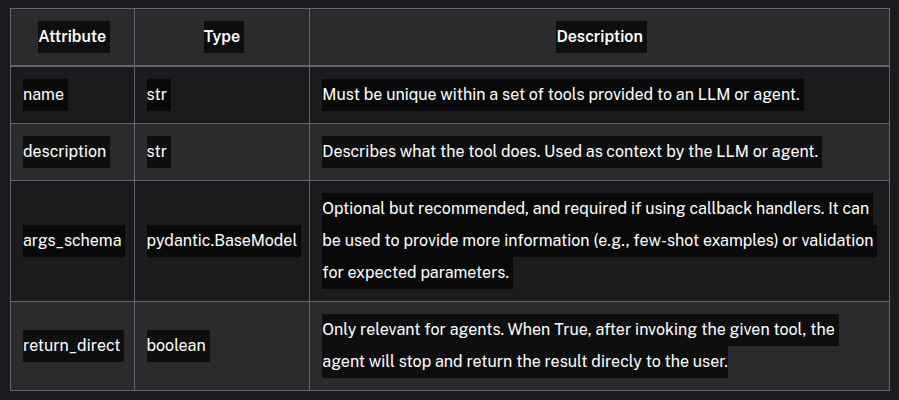

LangChain supports the creation of tools from:

1) Functions;

2) LangChain Runnables;

3) By sub-classing from BaseTool;

**Creating tools from functions**

@tool decorator

This @tool decorator is the simplest way to define a custom tool. The decorator uses the function name as the tool name by default, but this can be overridden by passing a string as the first argument. Additionally, the decorator will use the function's docstring as the tool's description.

In [1]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [2]:
# Or create an async implementation, like this:

from langchain_core.tools import tool


@tool
async def amultiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

**StructuredTool**

The StructuredTool.from_function class method provides a bit more configurability than the @tool decorator, without requiring much additional code.

In [3]:
from langchain_core.tools import StructuredTool


def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


async def amultiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


calculator = StructuredTool.from_function(func=multiply, coroutine=amultiply)

print(calculator.invoke({"a": 2, "b": 3}))
print(await calculator.ainvoke({"a": 2, "b": 5}))

6
10


**How to use built-in tools and toolkits**

LangChain has a large collection of 3rd party tools. Please visit Tool Integrations for a list of the available tools.

In [5]:
!pip install -qU langchain-community wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


In [15]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
tool = WikipediaQueryRun(api_wrapper=api_wrapper)

print(tool.invoke({"query": "langchain"}))

Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


In [8]:
print(f"Name: {tool.name}")
print(f"Description: {tool.description}")
print(f"args schema: {tool.args}")
print(f"returns directly?: {tool.return_direct}")

Name: wikipedia
Description: A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
args schema: {'query': {'description': 'query to look up on wikipedia', 'title': 'Query', 'type': 'string'}}
returns directly?: False


How to pass tool outputs to chat models

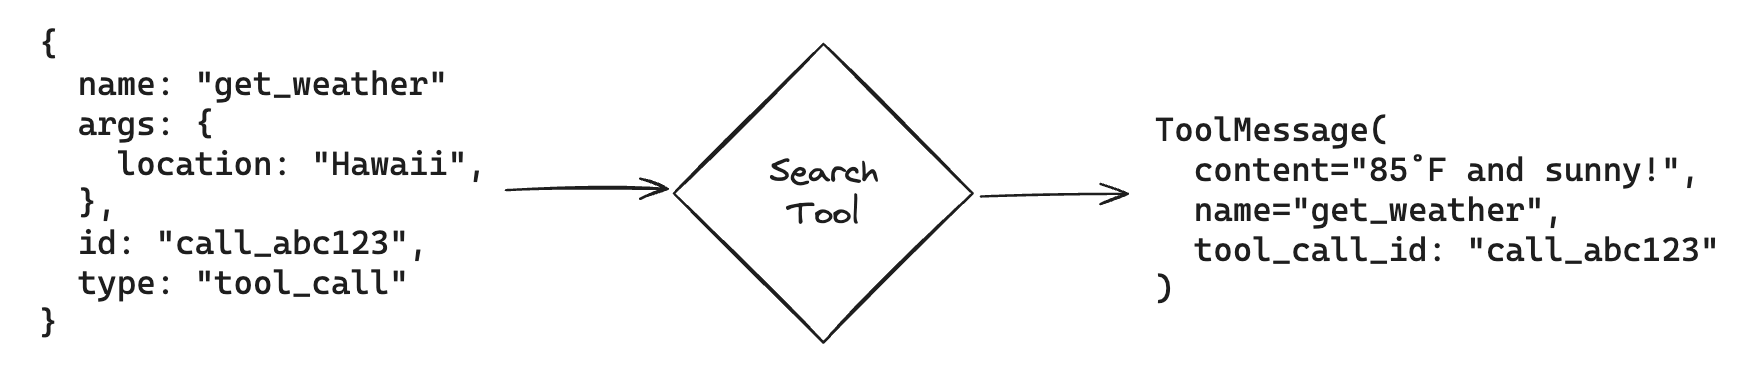

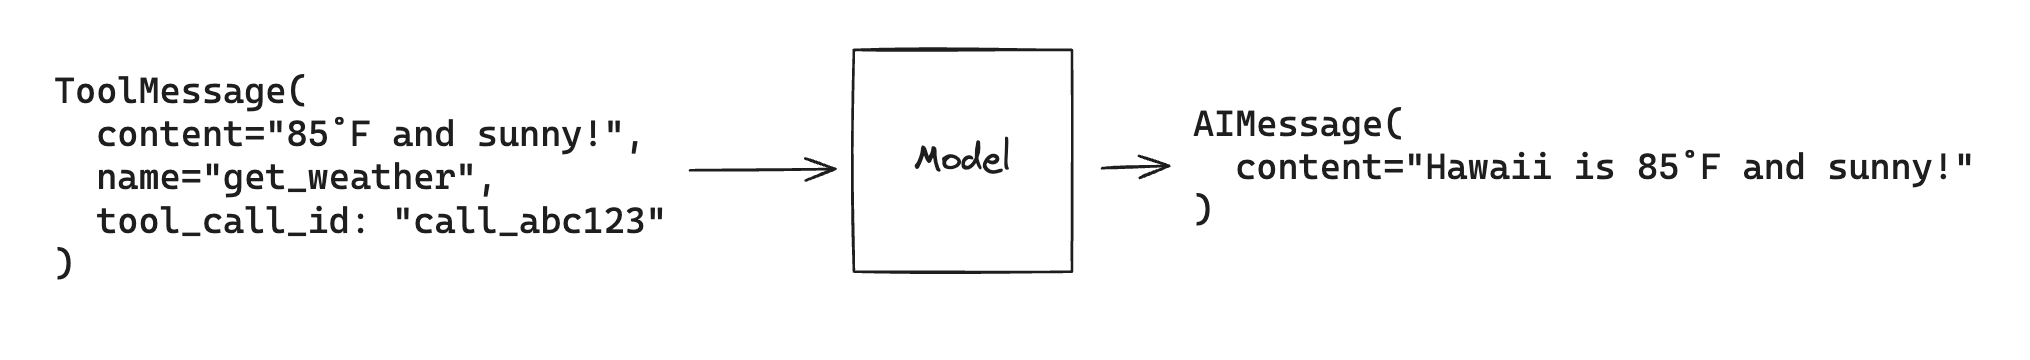

In [17]:
!pip install -U langchain-mistralai

In [35]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

from langchain.chat_models import init_chat_model

# llm = init_chat_model("mistral-large-latest", model_provider="mistralai")

# from langchain.chat_models import init_chat_model

model = init_chat_model("meta/llama3-70b-instruct", model_provider="nvidia")

In [36]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

llm_with_tools = llm.bind_tools(tools)

In [37]:
from langchain_core.messages import HumanMessage

query = "What is 3 * 12? ?"

messages = [HumanMessage(query)]

print(messages)

ai_msg = llm_with_tools.invoke(messages)

print(ai_msg.tool_calls)

messages.append(ai_msg)

query = "Also, what is 11 + 49 ?"

messages = [HumanMessage(query)]

print(messages)

ai_msg = llm_with_tools.invoke(messages)

print(ai_msg.tool_calls)

messages.append(ai_msg)

print(messages)

[HumanMessage(content='What is 3 * 12? ?', additional_kwargs={}, response_metadata={})]
[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'vUtE7h0OH', 'type': 'tool_call'}]
[HumanMessage(content='Also, what is 11 + 49 ?', additional_kwargs={}, response_metadata={})]
[{'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'ZddWqnWiO', 'type': 'tool_call'}]
[HumanMessage(content='Also, what is 11 + 49 ?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ZddWqnWiO', 'function': {'name': 'add', 'arguments': '{"a": 11, "b": 49}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 153, 'total_tokens': 180, 'completion_tokens': 27}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run-214a00ba-5c54-4d10-8ace-8a9fd9b0661a-0', tool_calls=[{'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'ZddWqnWiO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'o

In [38]:
for tool_call in ai_msg.tool_calls:
    print("check this---->",tool_call)
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

print("this is msg--->",messages)

check this----> {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'ZddWqnWiO', 'type': 'tool_call'}
this is msg---> [HumanMessage(content='Also, what is 11 + 49 ?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ZddWqnWiO', 'function': {'name': 'add', 'arguments': '{"a": 11, "b": 49}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 153, 'total_tokens': 180, 'completion_tokens': 27}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run-214a00ba-5c54-4d10-8ace-8a9fd9b0661a-0', tool_calls=[{'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'ZddWqnWiO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 27, 'total_tokens': 180}), ToolMessage(content='60', name='add', tool_call_id='ZddWqnWiO')]


In [39]:
final_response = llm_with_tools.invoke(messages)
print(final_response.content)

11 + 49 equals 60.


**How to pass run time values to tools**